In [19]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [20]:
x = []
y = []
gesture_classes = []
filenames = ['no', 'one', 'two', 'three', 'four', 'undo']
npy_files = os.path.join("data", "*.npy")

for filename in filenames:
    npy_file = os.path.join("data", f"{filename}.npy")
    basename = os.path.basename(filename)
    gesture_class = basename.replace('.npy', '')
    
    data = np.load(npy_file)
    x.extend(data)
    y.extend([gesture_class] * len(data))
    
    if gesture_class not in gesture_classes:
        gesture_classes.append(gesture_class)

x = np.array(x)
y = np.array(y)

In [21]:
print(f"Feature dimension: {x.shape[1]}")  # 18
print(f"Gesture classes: {gesture_classes}")
print(f"Class distribution:")
unique, counts = np.unique(y, return_counts=True)
for class_name, count in zip(unique, counts):
    print(f"  {class_name}: {count} samples")

Feature dimension: 18
Gesture classes: ['no', 'one', 'two', 'three', 'four', 'undo']
Class distribution:
  four: 300 samples
  no: 900 samples
  one: 300 samples
  three: 300 samples
  two: 300 samples
  undo: 300 samples


In [22]:
y_encoded = np.array([{label: i for i, label in enumerate(gesture_classes)}[label] for label in y])
num_classes = len(gesture_classes)
print("Original:", y)
print("Encoded: ", y_encoded)
indices = np.random.permutation(len(x))
x_shuffled = x[indices]
y_shuffled = y_encoded[indices]

Original: ['no' 'no' 'no' ... 'undo' 'undo' 'undo']
Encoded:  [0 0 0 ... 5 5 5]


In [23]:
mean_values = np.mean(x_shuffled, axis=0)
std_values = np.std(x_shuffled, axis=0)

# Simpan parameter normalisasi
np.save('normalization_mean5.npy', mean_values)
np.save('normalization_std5.npy', std_values)

# Normalisasi pada fitur data training
x_normalized = (x_shuffled - mean_values) / std_values

# Split data into train, validation, and test sets
x_train, x_temp, y_train, y_temp = train_test_split(
    x_normalized, y_shuffled, test_size=0.3, random_state=42, stratify=y_shuffled
)

x_val, x_test, y_val, y_test = train_test_split(
    x_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"normalized features: {x_normalized}")
print(f"Training samples: {len(x_train)}")
print(f"Validation samples: {len(x_val)}")
print(f"Test samples: {len(x_test)}")

normalized features: [[ 0.07541783  0.48870448 -0.15291106 ... -0.44532095 -0.07376231
  -0.03385168]
 [ 2.88336142 -0.38418665 -0.72804443 ... -1.3911644   2.26703366
  -0.8192025 ]
 [ 0.65310716  0.44661306 -0.56688939 ... -1.10458425  1.05906714
   0.94304561]
 ...
 [ 0.29020759  0.59566987  0.04785787 ... -0.26115015  0.19788889
  -0.3027093 ]
 [-0.64909178  1.47847921  0.71706151 ...  0.82576689 -0.84968225
  -0.66057893]
 [-0.79319881 -0.6856712   0.15535848 ... -1.19490861 -1.05785554
  -0.31041015]]
Training samples: 1680
Validation samples: 360
Test samples: 360


In [24]:
model = models.Sequential([
    # Input layer
    tf.keras.Input(shape=(18, 1)),
    
    # First convolutional blockz
    layers.Conv1D(32, kernel_size=3, activation='relu', padding='same'),
    
    # Second convolutional block
    layers.Conv1D(64, kernel_size=3, activation='relu', padding='same'),
    
    # Global max pooling
    layers.GlobalMaxPool1D(),
    # Dense layers
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),

    # Output layer
    layers.Dense(num_classes, activation='softmax')
])

In [25]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Display model architecture
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)               │ (None, 18, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 18, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_2          │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,886 (42.52 KB)

 Trainable params: 10,886 (42.52 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
from sklearn.metrics import precision_score, recall_score, f1_score, average_precision_score
import numpy as np
import tensorflow as tf

class MetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self, x_val, y_val):
        super().__init__()
        self.x_val = x_val
        self.y_val = y_val
        self.precision = []
        self.recall = []
        self.f1 = []
        self.map = []

    def on_epoch_end(self, epoch, logs=None):
        y_pred_prob = self.model.predict(self.x_val, verbose=0)
        y_pred = np.argmax(y_pred_prob, axis=1)

        # If labels are already class indices (1D), no need to argmax
        if len(self.y_val.shape) == 1:
            y_true = self.y_val
        else:
            y_true = np.argmax(self.y_val, axis=1)

        # Compute metrics
        precision = precision_score(y_true, y_pred, average='macro')
        recall = recall_score(y_true, y_pred, average='macro')
        f1 = f1_score(y_true, y_pred, average='macro')

        # mAP needs one-hot y_true, so use self.y_val directly if it's one-hot
        try:
            map_score = average_precision_score(self.y_val, y_pred_prob, average='macro')
        except ValueError:
            map_score = None  # or 0.0 if you want default fallback

        # Store
        self.precision.append(precision)
        self.recall.append(recall)
        self.f1.append(f1)
        self.map.append(map_score)

        # Print
        map_display = f"{map_score:.4f}" if map_score is not None else "N/A"
        print(f"\nEpoch {epoch+1} - Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, mAP: {map_display}")


In [27]:
# Train the model

metrics_callback = MetricsCallback(x_val, y_val)

history = model.fit(
    x_train, y_train,
    batch_size=32,
    epochs=60,
    validation_data=(x_val, y_val),
    callbacks=[metrics_callback],
    verbose=1
)

Epoch 1/60
37/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3350 - loss: 1.6892
Epoch 1 - Precision: 0.0625, Recall: 0.1667, F1: 0.0909, mAP: 0.5882
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.3458 - loss: 1.6706 - val_accuracy: 0.3750 - val_loss: 1.5043
Epoch 2/60
35/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3711 - loss: 1.5088

c:\Users\Admin\Desktop\Project\hand-mcq-rtc\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])



Epoch 2 - Precision: 0.5084, Recall: 0.1889, F1: 0.1330, mAP: 0.6270
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3705 - loss: 1.4901 - val_accuracy: 0.3917 - val_loss: 1.2973
Epoch 3/60
37/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4204 - loss: 1.3141

c:\Users\Admin\Desktop\Project\hand-mcq-rtc\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])



Epoch 3 - Precision: 0.7335, Recall: 0.6222, F1: 0.6456, mAP: 0.7037
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4323 - loss: 1.2890 - val_accuracy: 0.6389 - val_loss: 1.0678
Epoch 4/60
37/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5524 - loss: 1.0593
Epoch 4 - Precision: 0.7991, Recall: 0.6222, F1: 0.6704, mAP: 0.8070
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5589 - loss: 1.0520 - val_accuracy: 0.6889 - val_loss: 0.8668
Epoch 5/60
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6921 - loss: 0.8495
Epoch 5 - Precision: 0.8461, Recall: 0.7519, F1: 0.7842, mAP: 0.8521
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6926 - loss: 0.8480 - val_accuracy: 0.7917 - val_loss: 0.7060
Epoch 6/60
37/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7679 - loss: 0.6696
Epoch 6 - Precision: 0.7935, Recall: 0.7963, F1: 0.7927, mAP: 0.8765
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7670 - loss: 0.6669 - val_accuracy: 0.7806 - val_loss: 0.5763
Epoch 7/60


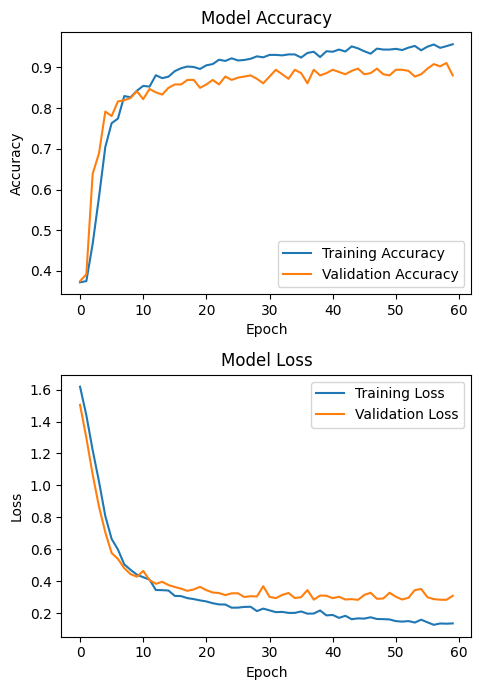

In [28]:
# Plot training history
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5, 7))

# Plot training & validation accuracy
ax1.plot(history.history['accuracy'], label='Training Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plot training & validation loss
ax2.plot(history.history['loss'], label='Training Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

plt.tight_layout()
plt.show()

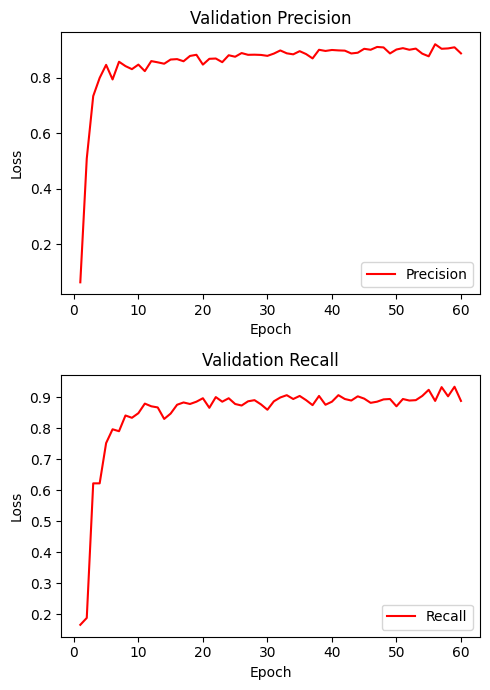

In [29]:
epochs = range(1, len(metrics_callback.precision) + 1)
fig, (pre, rec) = plt.subplots(2, 1, figsize=(5, 7))

pre.plot(epochs, metrics_callback.precision, label='Precision', color='red')
rec.plot(epochs, metrics_callback.recall, label='Recall', color='red')

pre.set_title('Validation Precision')
pre.set_xlabel('Epoch')
pre.set_ylabel('Loss')
pre.legend(loc='lower right')

rec.set_title('Validation Recall')
rec.set_xlabel('Epoch')
rec.set_ylabel('Loss')
rec.legend(loc='lower right')

plt.tight_layout()
plt.show()

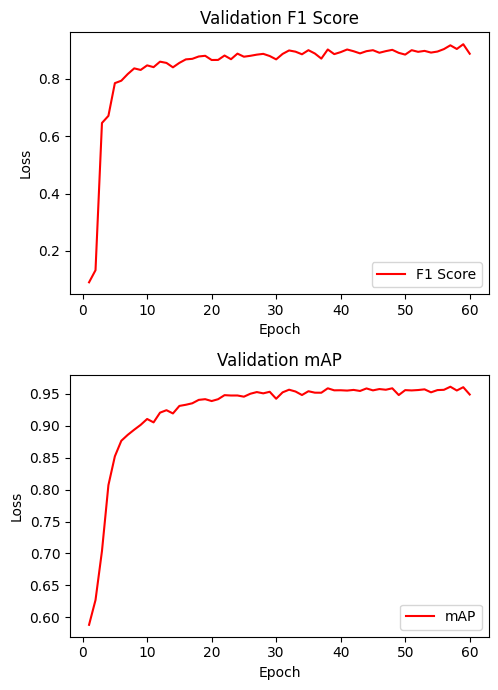

In [32]:
fig, (f1s, map) = plt.subplots(2, 1, figsize=(5, 7))

f1s.plot(epochs, metrics_callback.f1, label='F1 Score', color='red')
map.plot(epochs, metrics_callback.map, label='mAP', color='red')

f1s.set_title('Validation F1 Score')
f1s.set_xlabel('Epoch')
f1s.set_ylabel('Loss')
f1s.legend(loc='lower right')

map.set_title('Validation mAP')
map.set_xlabel('Epoch')
map.set_ylabel('Loss')
map.legend(loc='lower right')

plt.tight_layout()
plt.show()

In [33]:
# Select the epochs you want to include
selected_epochs = list(range(1, 11)) + [15, 20, 25, 30]

print("Epoch | Precision | Recall | F1 Score | mAP")
print("---------------------------------------------")

for i in selected_epochs:
    epoch_index = i - 1  # zero-based index
    print(f"{i:>5} | {metrics_callback.precision[epoch_index]:>9.4f} | "
          f"{metrics_callback.recall[epoch_index]:>6.4f} | "
          f"{metrics_callback.f1[epoch_index]:>8.4f} | "
          f"{metrics_callback.map[epoch_index]:>6.4f}")


Epoch | Precision | Recall | F1 Score | mAP
---------------------------------------------
    1 |    0.0625 | 0.1667 |   0.0909 | 0.5882
    2 |    0.5084 | 0.1889 |   0.1330 | 0.6270
    3 |    0.7335 | 0.6222 |   0.6456 | 0.7037
    4 |    0.7991 | 0.6222 |   0.6704 | 0.8070
    5 |    0.8461 | 0.7519 |   0.7842 | 0.8521
    6 |    0.7935 | 0.7963 |   0.7927 | 0.8765
    7 |    0.8573 | 0.7901 |   0.8159 | 0.8858
    8 |    0.8416 | 0.8407 |   0.8356 | 0.8938
    9 |    0.8306 | 0.8333 |   0.8301 | 0.9014
   10 |    0.8469 | 0.8481 |   0.8461 | 0.9106
   15 |    0.8652 | 0.8469 |   0.8548 | 0.9311
   20 |    0.8470 | 0.8963 |   0.8648 | 0.9387
   25 |    0.8753 | 0.8778 |   0.8762 | 0.9456
   30 |    0.8785 | 0.8593 |   0.8669 | 0.9423


In [34]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, average_precision_score

y_pred_prob = model.predict(x_test)
y_pred = np.argmax(y_pred_prob, axis=1)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')  # or 'weighted'
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
map_score = average_precision_score(y_test, y_pred_prob, average='macro')  # if y_val is one-hot

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


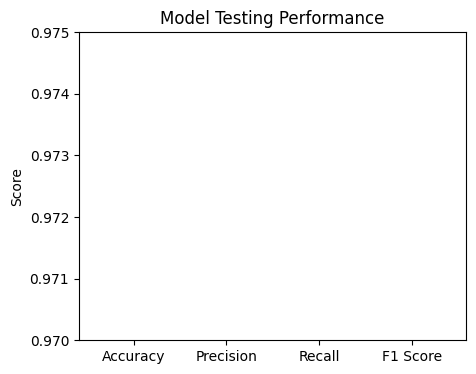

In [35]:
scores = [accuracy, precision, recall, f1]
labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

plt.figure(figsize=(5, 4))
bars = plt.bar(labels, scores, color=['#57d8f5', '#ffad5a', '#6ffd4f', '#020661'])
plt.ylim(0.97, 0.975)
plt.title('Model Testing Performance')
plt.bar_label(bars, label_type='edge')
plt.ylabel('Score')
plt.show()

Test Accuracy: 0.9111
Test Loss: 0.2936
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

Classification Report:
              precision    recall  f1-score   support

          no       0.87      0.93      0.90       135
         one       1.00      0.93      0.97        45
         two       0.96      0.98      0.97        45
       three       0.93      0.91      0.92        45
        four       0.95      0.84      0.89        45
        undo       0.84      0.84      0.84        45

    accuracy                           0.91       360
   macro avg       0.93      0.91      0.92       360
weighted avg       0.91      0.91      0.91       360



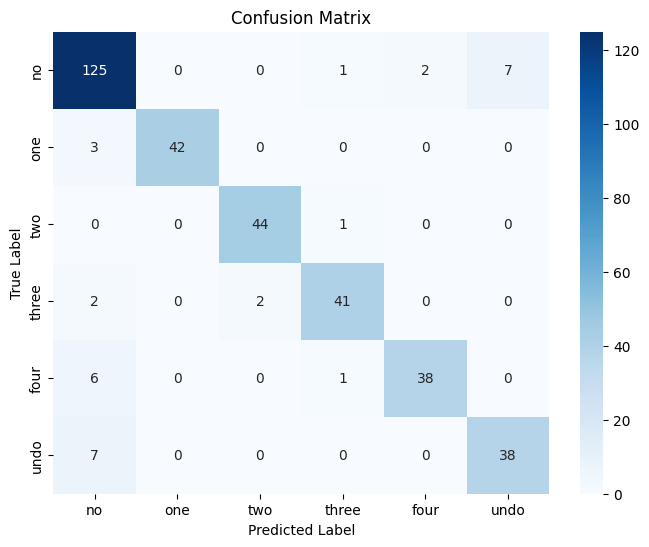

In [36]:
# Evaluate on test set
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Make predictions
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification report
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes, 
                          target_names=gesture_classes))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=gesture_classes,
            yticklabels=gesture_classes)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [56]:
# Save the trained model
model.save('gesture_quiz5.h5')